# Diplomatura en Ciencia de Datos, Aprendizaje Automático y sus Aplicaciones

<center>
<img 
     src="http://www2.famaf.unc.edu.ar/~efernandez/egeo/img/logos/famaf.jpg" 
     alt="Drawing" 
     style="width:30%;"
/>
</center>

# Entregable 3


# Practico: Aprendizaje Supervisado


## Grupo 2. Integrantes:
* Aranda, Franco.
* Carazo, Fernando Diego
* Molina, Florencia
* Taié Mirón, Macarena. 


### Consigna


# Primera parte: Preparación de los sets de datos


#### Consigna: obtener un dataset de cada paciente y uno con los datos de los tres pacientes (deberá tener cuatro datasets). 

En base a lo visto hasta el momento, quizás sea mas predecible el estado pre-ictal separando el análisis por paciente. Vamos a evaluar este supuesto comparando el desempeño de los modelos. Para eso necesitamos los datasets separados. 

----

#### Consigna: Hacer **filtros de outliers** (ver archivo de ejemplo) para cada uno de los conjuntos de datos obtenidos en el punto anterior.

Si bien el tratamiento de escalado y curado de datos nulos es igual que en el práctico de curación, no aplica para el estudio de outliers; por lo tanto, deberá realizarse nuevamente para cada uno de los conjuntos de datos obtenidos en el punto anterior.

----

Al final de esta parte del entregable deberán tener cuatro datasets y cuatro filtros de outliers.

---
---

---
---

#### 1- obtener un dataset de cada paciente y uno con los datos de los tres pacientes (deberá tener cuatro datasets). 

##### Cargamos los módulos.

In [32]:
# 1- generic modules-
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# to use in outliers deletion-.
from sklearn.base import BaseEstimator, TransformerMixin

# to define numbers of subplots dynamically-.
from matplotlib import gridspec

# @ to build a pipeline with balancer-.
from imblearn.pipeline import Pipeline as imbpipeline
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import Pipeline

# @ to balance-.
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler
# from imblearn.over_sampling import RandomOverSampler
from imblearn.combine import SMOTEENN
# from imblearn.over_sampling import BorderlineSMOTE, KMeansSMOTE, SVMSMOTE

# @ feature selection-.
# from sklearn.feature_selection import SelectFromModel
# https://towardsdatascience.com/5-feature-selection-method-from-scikit-learn-you-should-know-ed4d116e4172
from sklearn.feature_selection import SelectKBest, mutual_info_classif
# from sklearn.ensemble import GradientBoostingClassifier
from sklearn.feature_selection import chi2

# @ transformar/normalizar-.
from sklearn.preprocessing import StandardScaler

# @ escalar los datos-.
from sklearn.preprocessing import MinMaxScaler, RobustScaler

# @ calculate metrics-.
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_auc_score
from scikitplot.metrics import plot_roc

# @ APIs to applied ML models-.
from sklearn import ensemble
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import ExtraTreeClassifier
from xgboost import XGBClassifier
from sklearn import linear_model
from sklearn.svm import SVC
from sklearn.svm import NuSVC
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, RandomizedSearchCV 
from sklearn.linear_model import LogisticRegression, SGDClassifier, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
import scipy.stats as st # to use with hiperparameter definition-.


sns.set_style("darkgrid")

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn


---
---

##### Funciones auxiliares

Bloques de funciones y métodos usadas a lo largo del práctico.

In [2]:
# function to drop outliers-.
def label_outliers_iqr_ac(df, k=1.5, verbose=False): # filter all columns of DF-.
    df = df.copy()
    outlier_col='outlier'
    for column in df.columns:
        if column != 'State':
            quartiles = df[column].quantile([.25, .75])
            iqr = np.abs(quartiles.iloc[1] - quartiles.iloc[0])
            tolerable_range = pd.Series([quartiles.iloc[0] - k*iqr - 0.01, quartiles.iloc[1] + k*iqr + 0.01 ])
            df[outlier_col] = (df[column].isna() | df[column].clip(*tolerable_range).isin(tolerable_range)) # clip sets values outside the range equal to the boundaries
            df = df[~df['outlier']]
            df= df. drop(outlier_col, axis=1)
    return df

In [3]:
# to print outliers in function of patients and state-. 
def plot_outliers(metr, df):
    fig, axes = plt.subplots(len(metr), figsize=(20,60))
    for i,column in enumerate(metr):
        #sns.boxenplot( y=, )
        axes[i].set_title(column)
        sns.boxplot(data=df, # este DF contiene los tres pacientes etiquetados-.
                    x="Patient", 
                    y=column,
                    palette="Set2",
                    fliersize=0,
                    hue='State',
                    ax=axes[i])
        sns.stripplot(data=df,
                      x="Patient",
                      y=column,
                      hue='State',
                      jitter=True,
                      palette="Set1",
                      dodge=True,
                      linewidth=1,
                      edgecolor='gray',
                      ax=axes[i])
        
    for ax in axes:
        ax.tick_params(axis='y')

In [4]:
# to print and plot confusion matrix in dataframes's list-. 
def plot_conf_mat_train_val(X_tr, y_tr, y_tr_pred, y_va, y_va_pred):
    #  evalute predictions-.
    for i in range(len(X_tr)):
        text = 'LogisticRegression - classification repport of TRAIN set' 
        print(len(text)*"=")
        print(text)
        if i ==0:
            j= '1+2+3'
        else:
            j=i
        print('PACIENTE ==> {0}'.format(j))
        print(len(text)*"=")
        print(metrics.classification_report(y_tr[i], y_tr_pred[i]))
        
        # Evaluate val-.
        text= 'LogisticRegression - classification repport of VALIDATION set'
        print(len(text)*"=")
        print(text)
        if i ==0:
            j= '1+2+3'
        else:
            j=i
        print('PACIENTE ==> {0}'.format(j))
        print(len(text)*"=")
        print(metrics.classification_report(y_va[i], y_va_pred[i]))
        
        fig, axes = plt.subplots(1,2, figsize=(13,5))
        
        ConfusionMatrixDisplay.from_predictions(y_tr[i],
                                                y_tr_pred[i],
                                                normalize='true',
                                                cmap='Greens',
                                                ax=axes[0])
        axes[0].set_title('TRAIN set')
    
        ConfusionMatrixDisplay.from_predictions(y_va[i],
                                                y_va_pred[i],
                                                normalize='true',
                                                cmap='viridis',
                                                ax=axes[1])
        axes[1].set_title('TEST set')
        plt.suptitle("Train and Test confussion matrix of patient {0}".format(j))

In [5]:
# to print accuracy of differents models-.
def scores_times(i, X_train,y_train, X_test, y_test, clf):
    scores = [] # [None]#*len(clfs)
    times = [] # [None]#*len(clfs)
    clf_labels= []
    for i_clf, clf in enumerate(clfs):
        start_time = time.time()
        clf_fit = clf.fit(X_train,y_train)
        score = clf_fit.score(X_test,y_test)
        scores= np.append(scores,np.round(score,3))
        times= np.append(times, np.round((time.time()- start_time),2))
    
        # print("--- %s seconds ---" % (time.time() - start_time))
        ##print("--- %s seconds ---" % (times[i_clf]))
    
        train_predictions = clf_fit.predict(X_train)
        accuracy = accuracy_score(y_train, train_predictions)
        print(f'Accuracy TRAIN SET {clf}: %.3f%%' % (accuracy * 100.0))
    
        test_predictions = clf.predict(X_test)
        accuracy = accuracy_score(y_test, test_predictions)
        print(f'Accuracy TEST SET {clf}: %.3f%%' % (accuracy * 100.0))

        clf_labels.append(clf.__class__.__name__)    
        print('La accuracy de',  clf.__class__.__name__, 'es', np.round(score,3), '\n')
    return scores, times, clf_labels


---
---

##### Cargamos los datasets.

Con el fin de sistematizar las aplicaciones a los conjuntos de datos con los que se trabajará, a continuación se crea una lista en la que se alamacenarán los conjuntos de datos de cada paciente y de los tres pacientes juntos. 

In [6]:
main_url = 'https://raw.githubusercontent.com/MentoriaDiploDatos2022/AnalisisYVisualizacion/master/data_preprocessed/'
d_n_e= 'Data_noEtiquetado_P'
d_e = 'Data_test_P'
ext_file= '.csv'
num_pat_e= 3
num_pat_ne= 3

# https://stupidpythonideas.blogspot.com/2013/05/why-you-dont-want-to-dynamically-create.html
for i in range(num_pat_ne):
    globals()['e_p{0}'.format(i+1)]= pd.read_csv(main_url+d_e+str(i+1)+ext_file)

etiquetados = pd.concat([e_p1,e_p2,e_p3]).sample(frac=1).reset_index(drop=True)

# armo una lista con los conjuntos de datos para posteriormente aplicar los mismos filtros, func a todos los DF-.
df_e= [etiquetados]
[df_e.append(globals()['e_p{0}'.format(i+1)]) for i in range(num_pat_e)]

[None, None, None]


---
---

##### Eliminamos lo datos nulos.

In [7]:
# vemos la cantidad de nulos en los cuatro DF.
[eval('df_e['+str(i)+']').isnull().sum().sum() for i in range(len(df_e))]

[71, 34, 32, 5]

In [8]:
# vemos la cantidad de datos nulos en cada conjunto de datos-.
for i in range(len(df_e)):
    if i==0:
        j='1+2+3'
    else:
        j=i
    porc_datos_eli= eval('df_e['+str(i)+']').dropna(axis=0).shape[0]/eval('df_e['+str(i)+']').shape[0]*100
    print('Paciente {0:<6}: registros eliminados = {1:.2f} %'.format(j, (100-porc_datos_eli)))

Paciente 1+2+3 : registros eliminados = 1.18 %
Paciente 1     : registros eliminados = 2.61 %
Paciente 2     : registros eliminados = 1.36 %
Paciente 3     : registros eliminados = 0.21 %


In [9]:
# eliminamos los registros con datos nulos
[eval('df_e['+str(i)+']').dropna(axis=0, inplace=True) for i in range(len(df_e))]

[None, None, None, None]

In [10]:
# chequeamos si existen datos nulos en los cuatro DF.
[eval('df_e['+str(i)+']').isnull().sum().sum() for i in range(len(df_e))]

[0, 0, 0, 0]

In [11]:
# vemos las dimensiones en los cuatro DF.
[eval('df_e['+str(i)+']').shape for i in range(len(df_e))]

[(5971, 11), (1268, 11), (2314, 11), (2389, 11)]

##### Comentario:

Se observa que los porcentajes de registros eliminados son bajos en todos los conjuntos datos. El paciente uno presenta la mayor cantidad de datos nulos, seguido por el paciente dos y finalmente por el paciente tres. La cantidad de datos nulos varìa inversamente proporcional a la cantidad de registros de cada conjunto de datos (paciente), es decir; el conjunto de datos del paciente tres presenta la mayor cantidad de registros y la menor cantidad de registros nulos, seguido por el conjunto de datos del paciente dos y finalmente por el conjunto de datos del paciente uno.


---
---

##### Eliminamos los outliers

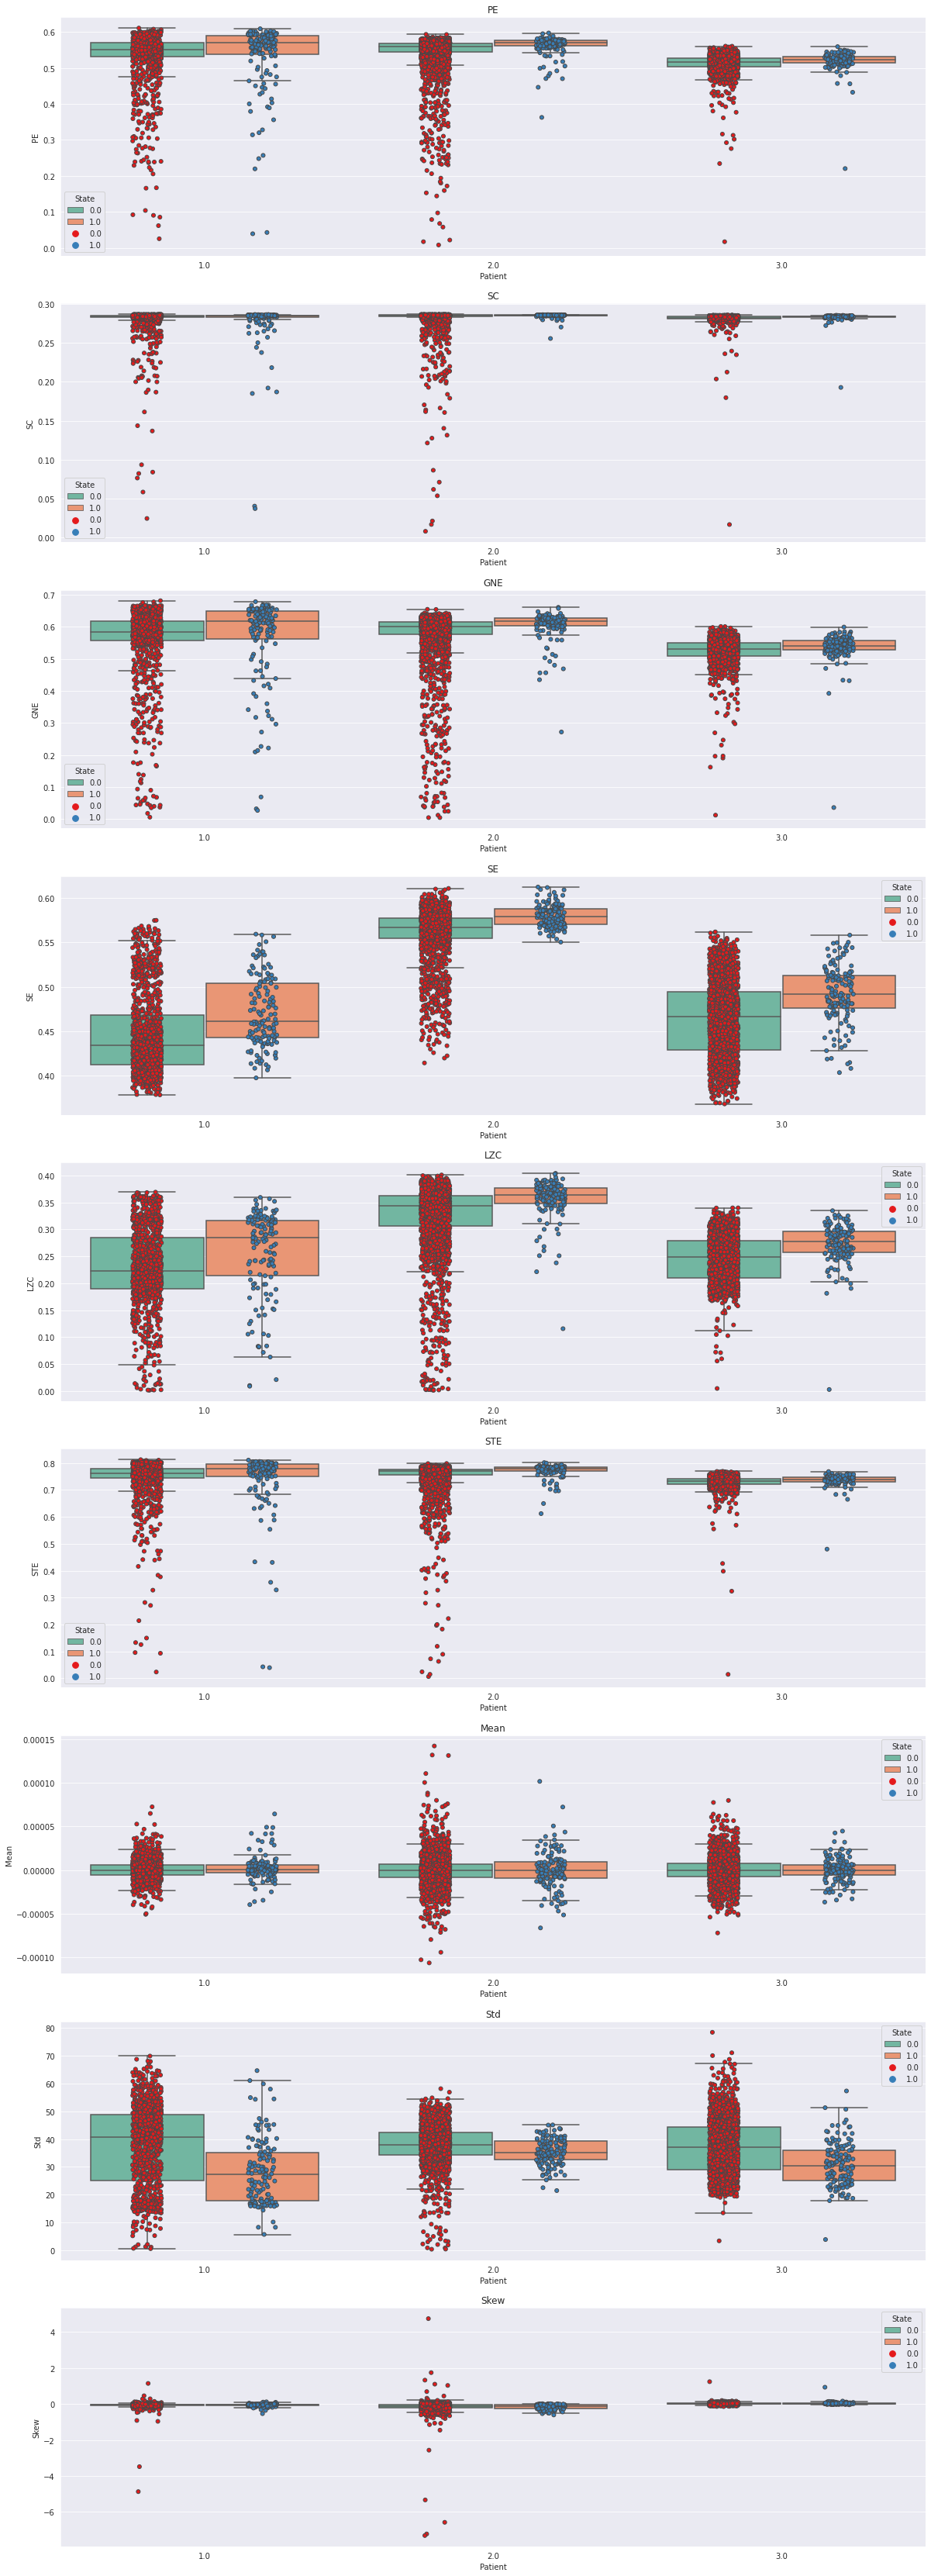

In [12]:
# primero visualizamos los conjuntos de datos (con outliers) de los tres pacientes-.
metricas = df_e[0].drop(axis=1, labels=["Patient", "State"]).columns
plot_outliers(metricas, df_e[0])

In [13]:
# eliminar outliers:
# me eliminaba todas las filas con 1 (unos), por eso tuve que agregar en la función
# un condicional para que no controle la columna State-.
outlier_tolerance_k = 1.5 # larger means you tolerate more extreme values. For gaussian data, standard is 1.5. 
dfs= list()
for i, data_frame in enumerate(df_e):
    df_filtered = label_outliers_iqr_ac(df_e[i],
                                        k=outlier_tolerance_k,
                                        verbose=True)
    dfs.append(df_filtered)
# [print(dfs[i]['State'].value_counts()) for i in range(len(dfs))]

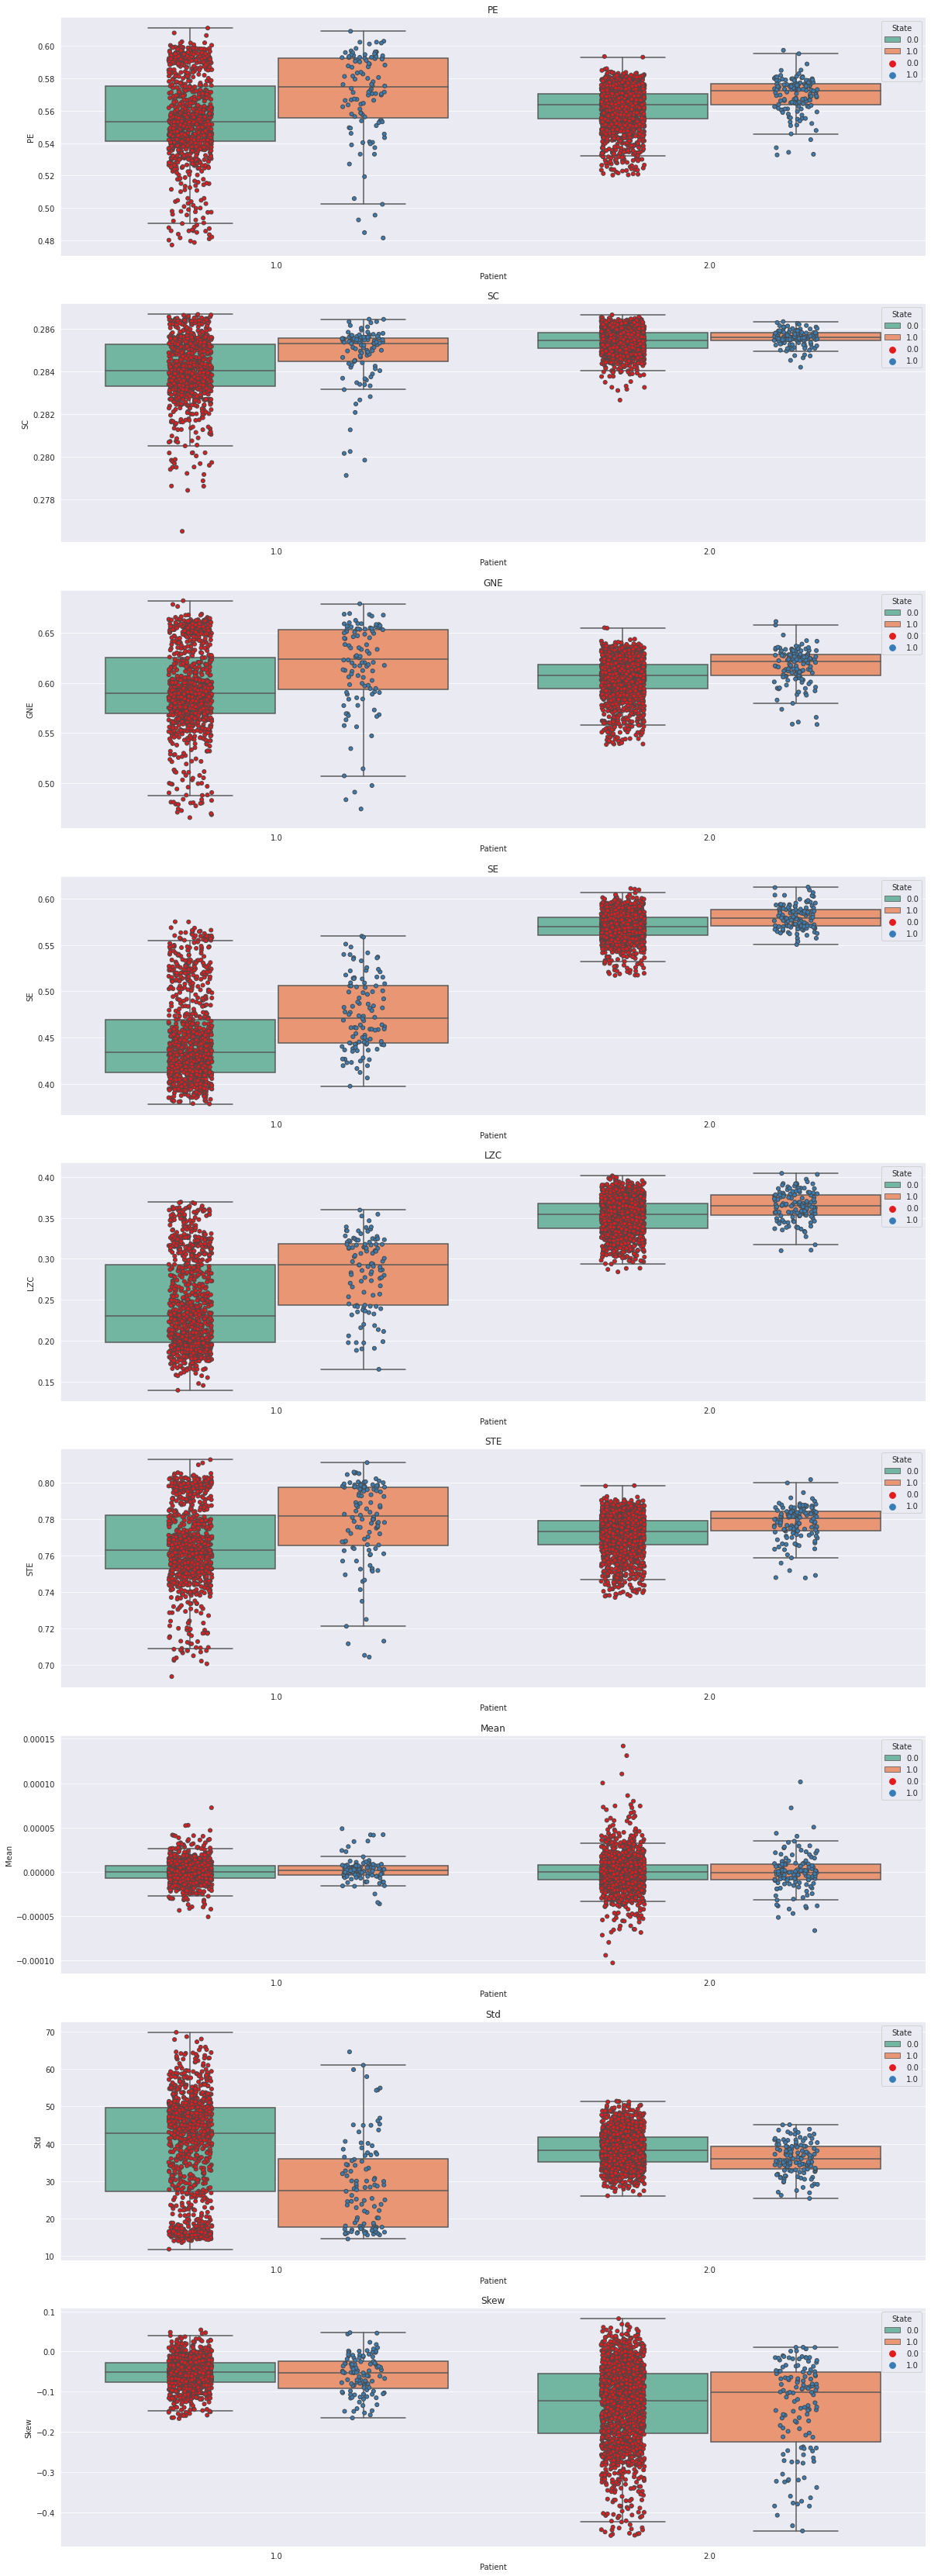

In [14]:
plot_outliers(metricas, pd.concat(dfs[1:3], ignore_index=True, sort=False))

Calculamos la cantidad de valores eliminados

In [15]:
#
[print('Paciente {0}: {1:<12} {2:.2f} %'.
       format(i, 
              'registros eliminados al sacar OUTLIERS =',
              (100-(dfs[i].shape[0]/df_e[i].shape[0]*100)))) for i in range(len(dfs))]

Paciente 0: registros eliminados al sacar OUTLIERS = 9.70 %
Paciente 1: registros eliminados al sacar OUTLIERS = 16.48 %
Paciente 2: registros eliminados al sacar OUTLIERS = 25.11 %
Paciente 3: registros eliminados al sacar OUTLIERS = 3.68 %


[None, None, None, None]

##### Comentario:

En este punto se observa que, considerando una distribución de cada feature para cada conjunto de datos de tipo normal o gaussiana, la cantidad de datos eliminados correspondientes a los outliers no es despreciable para los conjuntos de datos de los pacientes uno y dos; en tanto el conjunto de datos con mayor cantidad de registros, correspondiente al paciente tres, es el que presenta la menor pérdida de registros al eliminar los outliers. Al comparar las figuras antes y luego de eliminar los registros con outliers en cada feature y paciente, se observa que si bien se eliminaron una gran cantidad de outliers, estos no fueron eliminados en su totalidad, esto se debió al criterio de, eliminando los outliers, tratar de conservar la mayor cantidad de registros posibles en cada conjunto de datos.  


---
---

# Segunda parte: Estudio de clasificadores

#### Consigna: instanciar un modelo inicial que se usará como base para comparar con otros modelos. Usar un modelo lineal (ver archivo de ejemplo)

El modelo base es una primera aproximación. No necesariamente estamos en busqueda de ajustar hiperparámetros para incrementar unas décimas el F1-Score, lo que buscamos es contar con la performance de un modelo en su ajuste/forma mas básica. De esa manera, cuando comencemos a trabajar en el ajuste del modelo y a usar otros modelos no lineales, las métricas no deberían ser más bajas que las obtenidas con el modelo base. 

---
#### Consigna: Elegir y justificar un modelo para seleccion de features

Ya se vió que puede existir cierta correlación entre algunas de nuestras features. Para asegurar la efectividad del dataset, vamos a usar algun modelo que prediga cuales son los mejores features.

Fuente: https://towardsdatascience.com/feature-selection-using-logistic-regression-model-efc949569f58

---
#### Consigna: Estudien, prueben, y diagnostiquen distintos clasificadores sobre nuestros set de datos. 

Prueben el dataset etiquetado separando por paciente y con el dataset completo (sin la columna de paciente). Por cada modelo: 

- Aplicar un selector de features
- Estudiar que los hiperparámetros se ajusten a nuestro dataset. 
- Refinar la básqueda de hiperparámetros usando gridsearchCV o RandomSearchCV (recuerden que mucho antes de los hiperparámetros, son los features los que más determinan la efectividad del modelo). 


Modelos propuestos (no limitarse a):

- Lineal (modelo base): LogisticRegression, SGDClassifier. _Fuente: https://scikit-learn.org/stable/modules/classes.html#module-sklearn.linear_model_
- SVM: SVC, NuSVC, LinearSVC. _Fuente: https://scikit-learn.org/stable/modules/svm.html_
- Ensemble:  BaggingClassifier, KNeighborsClassifier, RandomForestClassifier. _Fuente: https://scikit-learn.org/stable/modules/ensemble.html_
- Opcional:
    - Deep Learning: Keras Sequential (ver ejemplo)


Por cada modelo usado debería haber algún análisis sobre los hiperparámetros que mejor se acomodan a nuestro dataset. No es necesario que se limiten a la lista de modelos propuesta. Pero debería haber como mínimo un modelo base, dos de SVM y dos de Ensemble. Pueden opcionalmente usar el VotingClassifier para combinar los resultados de los clasificadores usados en un modelo nuevo

#### Consigna: Armar una grilla de resultados (ver archivo de ejemplo) y realizar conclusiones.

Nota: Recuerden que las conclusiones no son únicamente acerca de cual es el mejor modelo. Cada modelo que instancian sufre una serie de modificaciones que pueden devenir de la teoría o más bien de la prueba y el error. El resgistro del análisis sobre el desempeño de los modelos nos va a permitir evaluarlos y ubicarlos en el contexto de nuestro dataset particular.



---
---

### Instanciamos un modelo inicial que se usará como modelo base

Comenzamos instanciando un modelo báscio lineal cuya métrica sirva de referencia en siguientes puntos de este entregable. El mismo se aplicará a los cuatro conjuntos de datos que obtuvimos en el punto anterior.

Solo con el fin de poner de manifiesto el desbalanceo de la variable target, a continuación se analiza la relación de etiquetas en la variable target. 

In [16]:
# Train and validation
# define a function-.
X_train, X_test, y_train, y_test= list(), list(), list(), list()

rs= 42
t_s= 0.30

for i in range(len(dfs)):
    X = dfs[i].drop(labels=['Patient', 'State'], axis=1).copy()
    y = dfs[i]['State'].copy()
    X_t, X_v, y_t, y_v = train_test_split(X,
                                          y,
                                          test_size= t_s,
                                          random_state=rs,
                                          shuffle=True
                                         )
    X_train.append(X_t), X_test.append(X_v), y_train.append(y_t), y_test.append(y_v)

# check target balance in data frames-.
for i in range(len(X_train)):
    print('{0:<45}{1:<2}) = 0/1 = {2}'.
          format('Balanceo etiquetas @ ENTRENAMIENTO (Paciente ',
                 i,
                 round(y_train[i].value_counts()[0]/y_train[i].value_counts()[1],2)))
    print('{0:<45}{1:<2}) = 0/1 = {2}'.
          format('Balanceo etiquetas @ TEST (Paciente ',
                 i,
                 round(y_test[i].value_counts()[0]/y_test[i].value_counts()[1],2)))

Balanceo etiquetas @ ENTRENAMIENTO (Paciente 0 ) = 0/1 = 12.53
Balanceo etiquetas @ TEST (Paciente          0 ) = 0/1 = 13.84
Balanceo etiquetas @ ENTRENAMIENTO (Paciente 1 ) = 0/1 = 8.15
Balanceo etiquetas @ TEST (Paciente          1 ) = 0/1 = 10.78
Balanceo etiquetas @ ENTRENAMIENTO (Paciente 2 ) = 0/1 = 12.78
Balanceo etiquetas @ TEST (Paciente          2 ) = 0/1 = 11.09
Balanceo etiquetas @ ENTRENAMIENTO (Paciente 3 ) = 0/1 = 15.6
Balanceo etiquetas @ TEST (Paciente          3 ) = 0/1 = 15.07


Ahora se procede a realizar el balanceo en los conjuntos de datos de entrenamiento solamente (para evitar el "Data Leakage" https://scikit-learn.org/dev/common_pitfalls.html -metrics overestimation- el balanceo no se aplica al conjunto de datos de test).

In [17]:
# undersampling majority class-.
undersample_ = RandomUnderSampler(random_state=rs,
                                  sampling_strategy=1.0)
# oversampling minirity class (using smote and adasyn)-.
smote_ = SMOTE(random_state=rs,
               sampling_strategy=1.0) # sampling_strategy = {0: 0.25, 1: 0.75}
adasyn_ = ADASYN(random_state=rs,
                 sampling_strategy='auto')
# combine Data Undersampling and Oversampling-.
smoteenn_ = SMOTEENN(random_state=rs,
                     sampling_strategy='all')

balancers_list= [undersample_, smote_, adasyn_, smoteenn_]
balancers_names= ['undersample', 'smote', 'adasyn', 'smoteenn']
steps = [('bl', smote_)]
# parameters = { }

pipeline = Pipeline(steps)
# grid = GridSearchCV(pipeline, param_grid=parameteres, cv=5)

for i in range(len(dfs)):
    print('{0}Paciente {1}'.format('\n',i))
    print('{0:<20}{1:<20}{2:<20}{3:<20}'.format('Balanceador',
                                         'tamaño original',
                                         'nuevo tamaño',
                                         'Balanceo de etiquetas'))
    for j in range(len(balancers_list)):
        len_old = len(y_train[i])
        X_tr, y_tr= balancers_list[j].fit_resample(X_train[i],
                                                   y_train[i]
                                                  )
        print('{0:<20}{1:<20}{2:<20}{3:<20}'.format(balancers_names[j],
                                                    len_old,
                                                    len(y_tr),
                                                    round(y_tr.value_counts()[0]/y_tr.value_counts()[1],2)
                                                   )
             )


Paciente 0
Balanceador         tamaño original     nuevo tamaño        Balanceo de etiquetas
undersample         3774                558                 1.0                 
smote               3774                6990                1.0                 
adasyn              3774                6995                1.0                 
smoteenn            3774                4720                0.79                

Paciente 1
Balanceador         tamaño original     nuevo tamaño        Balanceo de etiquetas
undersample         741                 162                 1.0                 
smote               741                 1320                1.0                 
adasyn              741                 1338                0.97                
smoteenn            741                 666                 0.87                

Paciente 2
Balanceador         tamaño original     nuevo tamaño        Balanceo de etiquetas
undersample         1213                176                 1.0       

##### Comentario:

Se observa que existe un desbalanceo de la variable target "proporcional" a la cantidad de registros en cada paciente, siendo, en todos los casos, mayor la cantidad de registros correspondientes a la clase 0. Respecto al desbalanceo en los conjuntos de entrenamiento y validación, para el paciente 1  (menor cantidad de registros) es prácticamente igual para ambos conjuntos de datos; para el paciente tres (mayor cantidad de registros), el conjunto de validación es la mitad del conjunto de entrenamiento; finalmente, para el paciente dos, el desbalanceo del conjunto de validación es aproximamdamente un cuarto menos del de entrenamiento.

Por otro lado y como se desprende de aplicar diferentes tipos de balanceadores al conjunto de entrenamiento, si bien ambos conjuntos de datos quedan balanceados, de la aplicación de diferentes tipos de balanceadores se desprende que:

1. **Submuestreando** la clase mayoritaria según la clase minoritaria, el tamaño de los conjuntos de datos disminuyen considerablemente perdiendo muchos registros en un conjunto de datos con pcos registros.
2. **Incrementando el muestreo** de la clase minoritaria según la clase mayoritaria tanto con SMOOTE y ADASYN, el tamaño aumenta hasta casi duplicar la cantidad de registros.
3. **Combinando** el **incremento** de la clase minoritaria con  SMOTE y el **submuestreo** con Edited Nearest Neighbors de la clase mayoritaria, el incremento de la cantidad de registros es inermedio entre Undersampling y Oversampling.

En función de lo mencionado y teniendo en cuenta que la dimensión del conjunto de datos es pequeña, se empleará el balanceo con ADASYN. 

In [18]:
for i in range(len(dfs)):
    X_train[i], y_train[i]= adasyn_.fit_resample(X_train[i],y_train[i])
    print('Balanceo etiquetas @ ENTRENAMIENTO (Paciente {0}) = 0/1 = {1}'.
          format(i, round(y_train[i].value_counts()[0]/y_train[i].value_counts()[1],2)))

Balanceo etiquetas @ ENTRENAMIENTO (Paciente 0) = 0/1 = 1.0
Balanceo etiquetas @ ENTRENAMIENTO (Paciente 1) = 0/1 = 0.97
Balanceo etiquetas @ ENTRENAMIENTO (Paciente 2) = 0/1 = 1.02
Balanceo etiquetas @ ENTRENAMIENTO (Paciente 3) = 0/1 = 1.0


Chequeamos si las columnas corrrespondientes a datos continuos y/o de tipo flotante, están normalizados.

In [19]:
# chequeo si la media de cada feature es == 0 y la desviación estándard == 1 (para ver si las 
# features están normalizadas)-.
for i in range(len(dfs)):
    X= dfs[i].drop(labels=['Patient', 'State'], axis=1)
    vals = pd.DataFrame({'mean': np.mean(X),
                         'var': np.var(X)
                        })

    if i==0:
        j='1+2+3'
    else:
        j=i
    print('Paciente {0}{1}{2}'.format(j,'\n',vals))
    print(np.mean(X.to_numpy()))
    print(np.var(X.to_numpy()))

Paciente 1+2+3
              mean           var
PE    5.380433e-01  9.284884e-04
SC    2.836428e-01  4.563544e-06
GNE   5.658108e-01  2.446509e-03
SE    4.973934e-01  3.890154e-03
LZC   2.805651e-01  3.841424e-03
STE   7.512920e-01  6.666258e-04
Mean -4.957385e-10  2.668504e-10
Std   3.755070e+01  9.107066e+01
Skew -4.338419e-02  7.047104e-03
4.491562909304454
146.7955632163062
Paciente 1
              mean           var
PE    5.573343e-01  6.941646e-04
SC    2.841614e-01  2.108003e-06
GNE   5.961801e-01  1.821296e-03
SE    4.501941e-01  2.218021e-03
LZC   2.490731e-01  3.105484e-03
STE   7.669780e-01  5.115220e-04
Mean  3.733560e-07  1.681758e-10
Std   3.794689e+01  2.076832e+02
Skew -5.353797e-02  1.509285e-03
4.53303019481145
162.702972115258
Paciente 2
              mean           var
PE    5.620261e-01  1.588566e-04
SC    2.854414e-01  2.724842e-07
GNE   6.053559e-01  4.054961e-04
SE    5.704196e-01  2.134421e-04
LZC   3.530449e-01  4.478297e-04
STE   7.721196e-01  1.126684e-04
Me

Como se demostró, los cuatro conjuntos de datos están desbalanceados y no han sido normalizados. Por lo tanto, para definir qué técnica de normalización y selector de features considerar antes de aplicar los diferentes modelos, se procederá de la siguiente manera:
1. Primero se definirá un caso base: para esto, los datos de entrenamiento balanceados se normalizarán y se aplicará un modelo de clasificación no lineal como el de regresión logística.
2. Con la finalidad de comparar los resultados obtenidos con el caso base, al caso anterior se le aplicarán otros modelos de normalizado y de selección de features. En este punto se pretende definir con qué normalizador y selector de features correr los diferentes modelos.

Con este procedimiento se busca minimizar los requerimientos y tiempos de cálculos a la hora de aplicar más de un modelo de clasificación.

In [20]:
# scalers
scaler_1_ = StandardScaler()
scaler_2_ = MinMaxScaler()
scaler_3_ = RobustScaler()
scalers_= [scaler_1_, scaler_2_, scaler_3_]

model_ = [LogisticRegression()] # base classification model-.

pipeline = Pipeline([
    # the scaler stage is indicated by param_grid-.
    ('ss', 'passthrough'),
    ("clf", model_)
])

param_grid = [
    {
        'ss': scalers_,
        'clf': model_,
        'clf__penalty': ['l1', 'l2'],
        'clf__random_state': [rs],
        'clf__solver': ['liblinear']#,
        #'clf__class_weight': ['balanced'] # if not balance, the model diverge-.
    }
]

model = GridSearchCV(pipeline, param_grid, scoring='neg_mean_squared_error',cv=5)

models= list() # empty list to save metrics obtained with differents data frames-. 
[models.append(model.fit(X_train[i], y_train[i])) for i in range(len(X_train))]
svr_cv= []
for i in range(len(X_train)):
    svr_cv.append(models[i])

In [21]:
[models[i].best_estimator_ for i in range(len(X_train))]

[Pipeline(steps=[('ss', StandardScaler()),
                 ('clf',
                  LogisticRegression(random_state=42, solver='liblinear'))]),
 Pipeline(steps=[('ss', StandardScaler()),
                 ('clf',
                  LogisticRegression(random_state=42, solver='liblinear'))]),
 Pipeline(steps=[('ss', StandardScaler()),
                 ('clf',
                  LogisticRegression(random_state=42, solver='liblinear'))]),
 Pipeline(steps=[('ss', StandardScaler()),
                 ('clf',
                  LogisticRegression(random_state=42, solver='liblinear'))])]

In [22]:
# predictions (train and test)-.
y_train_pred=  []
y_test_pred= []

[y_train_pred.append(models[i].predict(X_train[i])) for i in range(len(X_train))]
[y_test_pred.append(models[i].predict(X_test[i])) for i in range(len(X_test))]

##for i in range(len(X_train)):
    ##unique, counts = np.unique(y_train_pred[i], return_counts=True)
    # print(dict(zip(unique, counts)))
    ##print('{0:.3f}'.format(accuracy_score(y_test[i], y_test_pred[i])))

[None, None, None, None]

LogisticRegression - classification repport of TRAIN set
PACIENTE ==> 1+2+3
              precision    recall  f1-score   support

         0.0       0.54      0.54      0.54      3495
         1.0       0.54      0.54      0.54      3500

    accuracy                           0.54      6995
   macro avg       0.54      0.54      0.54      6995
weighted avg       0.54      0.54      0.54      6995

LogisticRegression - classification repport of VALIDATION set
PACIENTE ==> 1+2+3
              precision    recall  f1-score   support

         0.0       0.94      0.54      0.69      1509
         1.0       0.07      0.50      0.13       109

    accuracy                           0.54      1618
   macro avg       0.50      0.52      0.41      1618
weighted avg       0.88      0.54      0.65      1618

LogisticRegression - classification repport of TRAIN set
PACIENTE ==> 1
              precision    recall  f1-score   support

         0.0       0.49      0.96      0.65       660
        

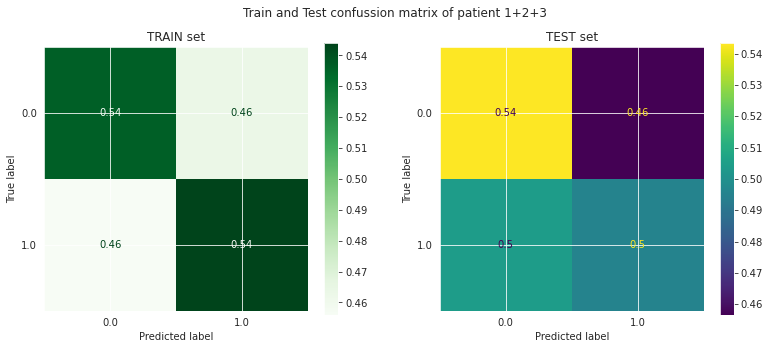

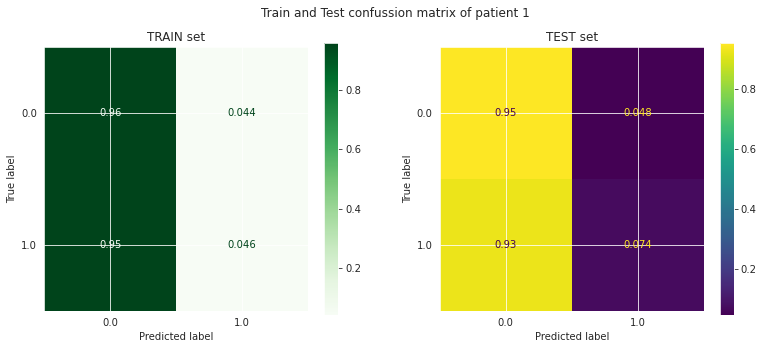

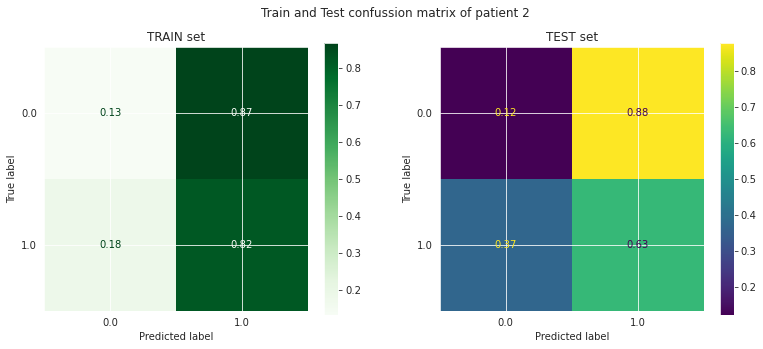

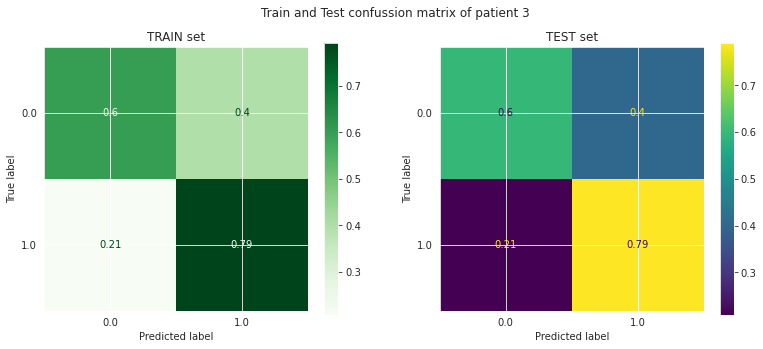

In [23]:
plot_conf_mat_train_val(X_train, y_train, y_train_pred, y_test, y_test_pred)

A continuación analizamos los resultados obtenidos con el modelo base para cada conjunto de datos:

* **Tres pacientes**
1. Conjunto de entrenamiento (balanceado): tiene la mayor cantidad de registros y está balanceado. Al analizar las métricas precission, recall, F1 y accuracy los valores son los mismos, **bajos pero constantes**, motivo por el cual y para ampliar el análisis que se hará, se procede a comentar la matriz de confusión para este caso. Un 46% de los registros correspondientes al estado preictal fueron clasificados como interictales y un 54% de las veces el estado era interictal y el modelo predijo el mencionado estado; por otro lado, un 54% de las veces el estado era preictal y el modelo predijo dicho estado, en tanto un 46% de las veces el estado era interictal y el modelo predijo el estado preictal. El análisis de la matriz de confusión llevado a cabo se ve reflejado en las métricas precission, recall, F1 y accuracy; para todas las métricas mencionadas, tanto para el estado interictal como preictal, el modelo reportó un 54% de aciertos (precission), un 54% de fallos (recall) y una accuracy del 54% (el F1 se omite pues es el premedio ponderado de precission y recall, y como los valores son los mismos y la cantidad aproximadamente igual, da 54% para los estados interictal y preictal). 

2. Conjunto de datos de validación (desbalanceado): en este caso la accuracy no es un métrica válida (ya que el conjunto está desbalanceado y el resultado no es representativo de los resultados de interés, sobre todo para la clase con menor cantidad de registros), motivo por el cual se procederá a analizar las métricas precission y recall. En el caso de precission se observa que para la clase con menor cantidad de registros correspondiente al estado preictal, solo un 7% de veces el modelo predijo y acertó dicho estado respecto al total de veces que predijo que el estado era preictal, básicamente o dicho de otra manera, solo un 7% de las veces el modelo predijo un estado preictal y acertó, en tanto en un 94% de los casos el el modelo predijo un estado interictal y acertó; por otro lado, para ambos estados, interictal y preictal, la cantidad de veces que el modelo falló fueron 50% y 54% de la veces respectivamente. Finalmente, el promedio ponderado de ambos métricas, F1 score, resulta bajo para la clase o estado preictal y mayor para la clase interictal.


* **Paciente UNO**
1. Conjunto de entrenamiento (balanceado): en este caso y aún cuando el conjunto de datos ha sido balanceado, la cantidad de fallas del modelo del estado preictal es muy alta; básicamente, muchas veces el modelo predice y acierta el estado preictal sobre el total de estados preictal del conjunto de datos. Por otro lado, la cantidad de aciertos para ambas clases, interictal y preictal, fueron del 49% y del 52% respectivamente. Finalmente, el F1 score es muy bajo para le estado preictal y mayor para el estado interictal (debido al bajo recall para la primer clase y/o estado). Finalmente y en función del análisis desarrollado se concluye que la accuracy no es una métrica representativa de este conjunto de datos. Estos resultados tienen su origen en la baja cantidad de registros de este conjunto de datos y en el desbalanceo de la variable a clasificar, solo un 8.15% de las etiquetas corresponden a un estado 0 (cero) o interictal.


2. Conjunto de datos de validación (desbalanceado): en este caso la accuracy no es un métrica válida (ya que el conjunto está desbalanceado y el resultado no es representativo de los resultados de interés, sobre todo para la clase con menor cantidad de registros), motivo por el cual se procederá a analizar las métricas precission y recall para dicha clase. En el caso de precission se observa que para la clase con menor cantidad de registros correspondiente al estado preictal, solo un 12% de veces el modelo predijo y acertó dicho estado respecto al total de veces que que dijo que el estado era preictal, básicamente o dicho de otra manera, solo un 12% de las veces el modelo predijo un estado preictal y acertó, en tanto en un 92% de los casos el modelo predijo un estado interictal y acertó; por otro lado, para ambos estados, preictal e itnerictal, la cantidad de veces que el modelo predijo y acertó el estado respecto al total de estados fueron 7% y 95% respectivamente. Finalmente, el promedio ponderado de ambos métricas, F1 score, resulta bajo para la clase o estado preictal y mayor para la clase interictal.

* **Paciente DOS**
1. Conjunto de entrenamiento (balanceado): a pesar de haber balanceado el conjunto de datos, la cantidad de fallas del modelo correspondiente a la predicción del estado interictal es muy alta; dicho de otra manera, pocas veces el modelo predice y acierta el estado interictal sobre el total de estados preictales del conjunto de datos (un 13% de los casos). Por otro lado, la cantidad de aciertos para ambas clases, interictal y preictal, fueron muy próximas entre sí e iguales a 43% y 48% respectivamente. Finalmente, el F1 score es muy bajo para le estado interictal y más alto para el estado preictal (debido al bajo recall para la clase y/o estado interictal). Finalmente y en función del análisis desarrollado se concluye que la accuracy no es una métrica representativa de este conjunto de datos. Estos resultados tienen su origen en la baja cantidad de registros de este conjunto de datos y en el desbalanceo de la variable a clasificar, solo un 12.78% de las etiquetas corresponden a un estado 0 (cero) o interictal.


2. Conjunto de datos de validación (desbalanceado): nuevamente y debido al desbalanceo de etiquetas, la accuracy no es un métrica válida (el resultado no es representativo de los resultados de interés, sobre todo para la clase que inicialemente cuenta con la menor cantidad de registros), motivo por el cual y al igual que para los conjuntos de datos/pacientes analizados, se analizarán las métricas precission y recall. En el caso de precission se observa que para la clase preictal, solo un 6% de veces el modelo predijo y acertó dicho estado respecto al total de veces que dijo que el estado era preictal, básicamente o dicho de otra manera, solo un 6% de las veces el modelo predijo un estado preictal y acertó, en tanto en un 79% de los casos el el modelo predijo un estado interictal y acertó; por otro lado, para ambos estados, interictal y preictal, en un 12% y un 63% de la veces el modelo predijo los estados mencionados y acertó respecto al total de estados correspondientes. Finalmente y como consecuencia de lo mencionado, el promedio ponderado de ambos métricas o F1 score, resulta bajo para ambas clases o estados, preictal e interictal.


* **Paciente TRES**
1. Conjunto de entrenamiento (balanceado): en este caso el análisis del conjunto de datos es análogo al delos **tres pacientes juntos**. Tanto la precission como el recall son aproxidamente iguales y por lo tanto el F1 score. Finalmente, para este caso podría decirse que la accuracy es representativa del conjunto de datos.


2. Conjunto de datos de validación (desbalanceado): nuevamente y debido al desbalanceo de etiquetas, la accuracy no es un métrica válida (el resultado no es representativo de los resultados de interés, sobre todo para la clase con menor cantidad de registros), motivo por el cual y al igual que para los conjuntos de datos/pacientes analizados, se analizarán las métricas precission y recall. En el caso de precission se observa que para la clase preictal, solo un 11% de veces el modelo predijo y acertó dicho estado respecto al total de veces que dijo que el estado era preictal, básicamente o dicho de otra manera, solo un 11% de las veces el modelo predijo un estado preictal y acertó, en tanto en un 98% de los casos el el modelo predijo un estado interictal y acertó; por otro lado, para ambos estados, interictal y preictal, en un 60% y un 79% de la veces el modelo predijo los estados mencionados y acertó respecto al total de estados correspondientes. Finalmente y como consecuencia de lo mencionado, el promedio ponderado de ambos métricas o F1 score, resulta bajo para la clse preictal y elevado para la clase interictal.


Conclusión parcial: los resultados presentados y analizados con el modelo base corresponden a las métricas precission, recall, F1 y accuracy, y a la matriz de confusión. Más allá de las métricas generales obtenidas para cada conjunto de datos (salvo el conjunto de datos balanceado de entrenamiento de los tres pacientes y para el paciente tres), los resultados ponen de manifiesto que la accuracy no es una métrica representativa de la precisión del modelo.


---
---

1. Habiendo definido el balanceo de los conjuntos de datos.
2. Habiendo definido el mejor método de estandarización.

A continuación se emplearán diferentes modelos de selección de features con el fin de analizar si las métricas obtenidas con le modelo base mejoran al aplicar estos transformadores.

In [24]:
# features selectors-.
feature_slect_1_ = SelectKBest(mutual_info_classif, k=5)
# feature_slect_2_ = SelectKBest(mutual_info_classif, k=5)
feature_slect_2_ = SelectKBest(score_func=chi2, k=5)

features_selects_= [feature_slect_1_, feature_slect_2_]

model_ = [LogisticRegression()] # base classification model-.

pipeline = Pipeline([
    # the scaler stage is indicated by param_grid-.
    ('fs', 'passthrough'),
    ("clf", model_)
])

param_grid = [
    {
        'fs': features_selects_,
        'clf': model_,
        'clf__penalty': ['l1', 'l2'],
        'clf__random_state': [rs],
        'clf__solver': ['liblinear']#,
        #'clf__class_weight': ['balanced'] # if not balance, the model diverge-.
    }
]

model = GridSearchCV(pipeline, param_grid, scoring='neg_mean_squared_error',cv=5)

models= list() # empty list to save metrics obtained with differents data frames-. 
[models.append(model.fit(X_train[i], y_train[i])) for i in range(len(X_train))]
svr_cv= []
for i in range(len(X_train)):
    svr_cv.append(models[i])

In [25]:
[models[i].best_estimator_ for i in range(len(X_train))]

[Pipeline(steps=[('fs',
                  SelectKBest(k=5,
                              score_func=<function mutual_info_classif at 0x7f7ddc31e4c0>)),
                 ('clf',
                  LogisticRegression(penalty='l1', random_state=42,
                                     solver='liblinear'))]),
 Pipeline(steps=[('fs',
                  SelectKBest(k=5,
                              score_func=<function mutual_info_classif at 0x7f7ddc31e4c0>)),
                 ('clf',
                  LogisticRegression(penalty='l1', random_state=42,
                                     solver='liblinear'))]),
 Pipeline(steps=[('fs',
                  SelectKBest(k=5,
                              score_func=<function mutual_info_classif at 0x7f7ddc31e4c0>)),
                 ('clf',
                  LogisticRegression(penalty='l1', random_state=42,
                                     solver='liblinear'))]),
 Pipeline(steps=[('fs',
                  SelectKBest(k=5,
                       

In [26]:
# predictions (train and test)-.
y_train_pred=  []
y_test_pred= []

[y_train_pred.append(models[i].predict(X_train[i])) for i in range(len(X_train))]
[y_test_pred.append(models[i].predict(X_test[i])) for i in range(len(X_train))]

for i in range(len(X_train)):
    unique, counts = np.unique(y_train_pred[i], return_counts=True)
    #print(dict(zip(unique, counts)))
    print('{0:.3f}'.format(accuracy_score(y_test[i], y_test_pred[i])))

0.459
0.692
0.083
0.586


Al comparar los valores de las métricas obtenidos con los del modelo base sin selección de features, se observa que en ningún caso las métricas del conjunto de entrenamiento para los cuatro conjuntos de datos mejoran

A continuación aplicamos el modelo obtenido y evaluamos las predicciones con el conjunto de validación.

LogisticRegression - classification repport of TRAIN set
PACIENTE ==> 1+2+3
              precision    recall  f1-score   support

         0.0       0.70      0.42      0.53      3495
         1.0       0.59      0.82      0.68      3500

    accuracy                           0.62      6995
   macro avg       0.64      0.62      0.60      6995
weighted avg       0.64      0.62      0.60      6995

LogisticRegression - classification repport of VALIDATION set
PACIENTE ==> 1+2+3
              precision    recall  f1-score   support

         0.0       0.96      0.44      0.60      1509
         1.0       0.09      0.74      0.16       109

    accuracy                           0.46      1618
   macro avg       0.52      0.59      0.38      1618
weighted avg       0.90      0.46      0.57      1618

LogisticRegression - classification repport of TRAIN set
PACIENTE ==> 1
              precision    recall  f1-score   support

         0.0       0.64      0.67      0.65       660
        

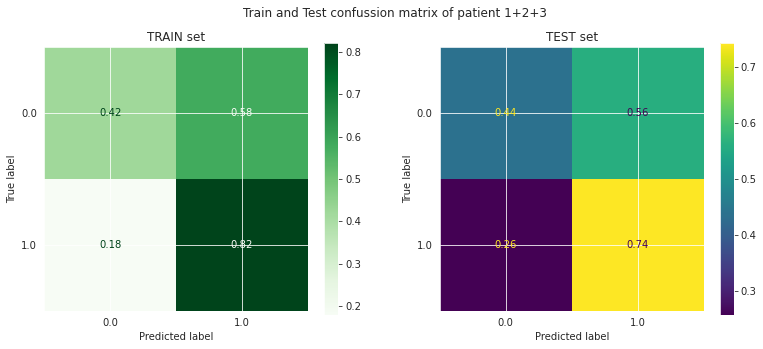

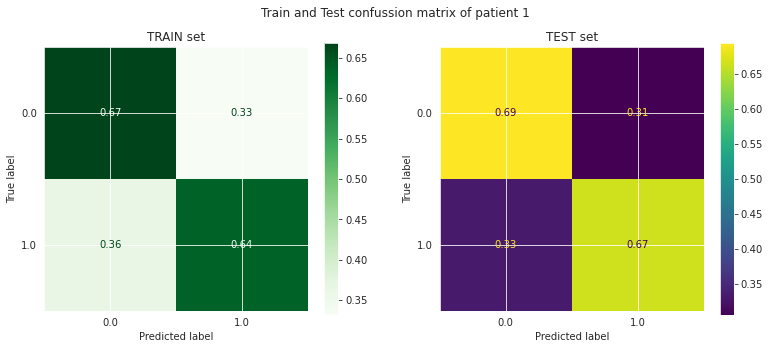

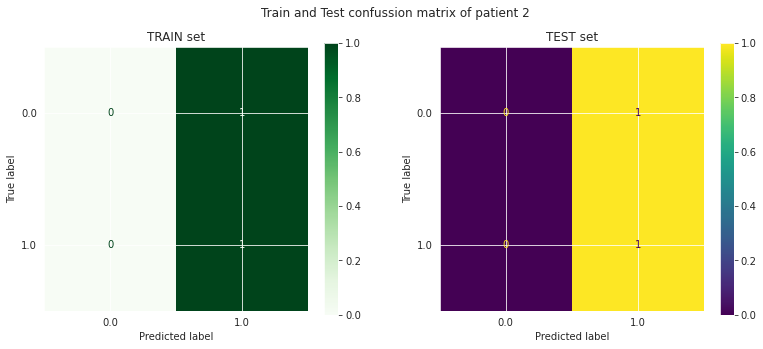

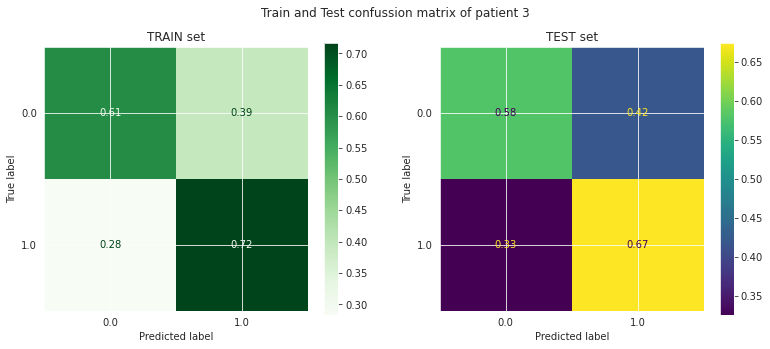

In [27]:
plot_conf_mat_train_val(X_train, y_train, y_train_pred, y_test, y_test_pred)

En general se observa que las métricas no mejoran. Nuevamente y teniendo en cuenta que el tamaño de los datasets es pequeño, para la aplicación de los diferentes modelos de clasificación no se considerará la selección de features. En general y más allá de algunas variaciones puntuales de las métricas para todos los conjuntos de datos, las conclusiones parciales correspondientes a este punto son las mismas y en algunos casos se observa un sobreajuste mayor debido al desbalanceo de los etiquetas. 

A continuación se procede a aplicar diferentes modelos de clasificación y de sus hiperparámetros.


---
---

### Consigna: Estudien, prueben, y diagnostiquen distintos clasificadores sobre nuestros set de datos. 
#### Preparamos los modelos y entrenamos

In [33]:
clfs = [RandomForestClassifier(random_state=rs),
        LogisticRegressionCV(solver='sag',
                             max_iter=10000,
                             random_state=rs
                            ),
        SGDClassifier(random_state=rs,
                      max_iter=10000
                     ),
        SVC(kernel='poly',
            max_iter=10000,
            random_state=rs
           ),
        NuSVC(kernel='poly',
              max_iter=10000,
              random_state=rs
             ),
        LinearSVC(max_iter=10000,
                  random_state=rs
                 ),
        DecisionTreeClassifier(criterion='entropy',
                               random_state=rs
                              ),
        ExtraTreeClassifier(random_state=rs
                           ),
        XGBClassifier(random_state=rs
                     )
       ]

In [34]:
scores_ret = [] # [None]#*len(clfs)
times_ret = [] # [None]#*len(clfs)

for i in range(len(dfs)):
    scores_list= []
    times_list= []
    scores_list, times_list, clf_labels= scores_times(i,
                                                      X_train[i],
                                                      y_train[i],
                                                      X_test[i],
                                                      y_test[i],
                                                      clfs
                                                     )
    scores_ret.append(scores_list)
    times_ret.append(times_list)

Accuracy TRAIN SET RandomForestClassifier(random_state=42): 100.000%
Accuracy TEST SET RandomForestClassifier(random_state=42): 82.447%
La accuracy de RandomForestClassifier es 0.824 

Accuracy TRAIN SET LogisticRegressionCV(max_iter=10000, random_state=42, solver='sag'): 64.832%
Accuracy TEST SET LogisticRegressionCV(max_iter=10000, random_state=42, solver='sag'): 64.895%
La accuracy de LogisticRegressionCV es 0.649 

Accuracy TRAIN SET SGDClassifier(max_iter=10000, random_state=42): 51.623%
Accuracy TEST SET SGDClassifier(max_iter=10000, random_state=42): 10.445%
La accuracy de SGDClassifier es 0.104 

Accuracy TRAIN SET SVC(kernel='poly', max_iter=10000, random_state=42): 65.818%
Accuracy TEST SET SVC(kernel='poly', max_iter=10000, random_state=42): 53.770%
La accuracy de SVC es 0.538 

Accuracy TRAIN SET NuSVC(kernel='poly', max_iter=10000, random_state=42): 60.214%
Accuracy TEST SET NuSVC(kernel='poly', max_iter=10000, random_state=42): 30.593%
La accuracy de NuSVC es 0.306 

Accu

Accuracy TRAIN SET RandomForestClassifier(random_state=42): 100.000%
Accuracy TEST SET RandomForestClassifier(random_state=42): 85.239%
La accuracy de RandomForestClassifier es 0.852 

Accuracy TRAIN SET LogisticRegressionCV(max_iter=10000, random_state=42, solver='sag'): 66.259%
Accuracy TEST SET LogisticRegressionCV(max_iter=10000, random_state=42, solver='sag'): 57.598%
La accuracy de LogisticRegressionCV es 0.576 

Accuracy TRAIN SET SGDClassifier(max_iter=10000, random_state=42): 52.974%
Accuracy TEST SET SGDClassifier(max_iter=10000, random_state=42): 12.012%
La accuracy de SGDClassifier es 0.12 

Accuracy TRAIN SET SVC(kernel='poly', max_iter=10000, random_state=42): 64.342%
Accuracy TEST SET SVC(kernel='poly', max_iter=10000, random_state=42): 49.638%
La accuracy de SVC es 0.496 

Accuracy TRAIN SET NuSVC(kernel='poly', max_iter=10000, random_state=42): 45.175%
Accuracy TEST SET NuSVC(kernel='poly', max_iter=10000, random_state=42): 62.373%
La accuracy de NuSVC es 0.624 

Accur

In [35]:
columns = ['Accuracy', 'Execution Time [s]']
acc= []
for i in range(len(dfs)):
    acc.append(pd.DataFrame(data = np.array([scores_ret[i],times_ret[i]]).T,
                     index = list(set(clf_labels)),
                     columns = columns
                    ).sort_values(by='Accuracy', ascending=False)
              )
    print('{0}Paciente  {1}{2}'.format('\n', i, acc[i]))


Paciente  0                        Accuracy  Execution Time [s]
ExtraTreeClassifier        0.824                1.79
SGDClassifier              0.808                1.13
LinearSVC                  0.781                0.11
RandomForestClassifier     0.722                0.01
XGBClassifier              0.649               38.45
LogisticRegressionCV       0.549                3.98
NuSVC                      0.538                2.30
DecisionTreeClassifier     0.306                1.18
SVC                        0.104                0.10

Paciente  1                        Accuracy  Execution Time [s]
SGDClassifier              0.808                0.49
ExtraTreeClassifier        0.796                0.43
LinearSVC                  0.774                0.02
SVC                        0.730                0.01
RandomForestClassifier     0.720                0.01
XGBClassifier              0.651               11.03
LogisticRegressionCV       0.651                0.61
NuSVC                 

#### Ajuste de hiperparámetros de los modelos con mejor score
Se seleccionarán para el análisis de hipoerparámetros los tres mjores clasificadores de cada paciente (solo se hará un análisis global, no se discriminará por paciente):


A continuación realizaremos el ajuste de hiperparámetros de los dos modelos con mejor Accuracy score:
1. SGD: conjunto de datos solo presente en  los tres pacientes juntos.
2. RF: presente en los cuatro conjuntos de datos.
3. XGBClassifier: presente en los cuatro conjuntos de datos.
4. SVC: presente solo en paciente 1.
5. LR: presente en los pacientes 2 y 3.
6. KN: solo para probar su comportamiento al optimizar hiperparámetros.

Para el análisis elejiremos los tres clasificadores que se encuentran presentes en mayor cantidad de pacientes.

In [36]:
one_to_left = st.beta(10, 1) # Esta distribución nos dará valores entre 0 y 1 mayormente cercanos a 1-.
#other_params = {'selector_num__poly__degree': [1, 2, 3]}   # [1, 2, 3]}

# https://stackoverflow.com/questions/50265993/alternate-different-models-in-pipeline-for-gridsearchcv
from sklearn.neighbors import KNeighborsClassifier
# the models that you want to compare
models = {
    'SGDClassifier': SGDClassifier(),
    'RandomForestClassifier': RandomForestClassifier(),
    'XGBClassifier': XGBClassifier(),
    'SVCClassifier': SVC(),  
    'LogisticRegressionClassifier': LogisticRegression(),
    'KNeighboursClassifier': KNeighborsClassifier(),
}

# the optimisation parameters for each of the above models
params = {
    'SGDClassifier': { # stochastic gradient descendent params-.
        'loss': ['log_loss', 'squared_error'], # 'perceptron'
        'penalty': ["l2", "l1", "elasticnet"],
        'learning_rate': ['constant', 'optimal', 'invscaling'],
        'power_t': [0.25,0.5, 1.0]  
    },
    'RandomForestClassifier': {
        'n_estimators': st.randint(20,150), # n. de árboles.
        'max_depth': st.randint(3, 12),     # máxima profundiad del árbol
        'max_features': ["sqrt", "log2"],
        'bootstrap': [True],
        'criterion': ['gini', 'entropy'],
        'oob_score': [True, False],
        'random_state': [rs]
    },
    'XGBClassifier': {
        'n_estimators': st.randint(20,150), # numero de árboles de decision.
        'max_depth': st.randint(3, 12),     # máxima profundiad del árbol
        'learning_rate': st.uniform(0.05, 0.4), # learning rate (xgb’s “eta”)
        'colsample_bytree': one_to_left, # ratio de la muestra de las columnas a la hora de construir el árbol
        'subsample': one_to_left,     # ratio de la muestra de las observaciones
        'reg_alpha': st.uniform(0.05,10),   # término de regularización L1
        'min_child_weight': st.uniform(1,20), # Suma mínima del peso de la instancia (hessiano) requerida en los hijo
        'random_state': [rs]
    },
    'SVCClassifier': { # support vector machine params-.
        'classifier__C': [10**x for x in range(-5, 3)],
        'classifier__kernel': ['linear', 'poly', 'rbf', 'sigmoid', 'precomputed'],
        'classifier__gamma': ['scale', 'auto'], # coeficiente @ los Kernels ‘rbf’, ‘poly’ y ‘sigmoid’-.
        'classifier__degree': [1, 2, 3, 4, 5],
        'random_state': [rs]
    },
    'LogisticRegressionClassifier': {
        'max_iter': [10000],
        'C': [10**x for x in range(-5, 3)],
        'solver': ['newton-cg', 'sag', 'lbfgs'],
        'multi_class': ['ovr', 'multinomial'],
        'random_state': [rs]
    },
    'KNeighboursClassifier': {
        'n_neighbors': np.arange(3, 15),
        'weights': ['uniform', 'distance'],
        'algorithm': ['ball_tree', 'kd_tree', 'brute'],
        'random_state':[rs]
    }
}

In [37]:
def fit(train_features, train_actuals):
        """
        fits the list of models to the training data, thereby obtaining in each 
        case an evaluation score after GridSearchCV cross-validation-.
        """
        for name in models.keys():
            est = models[name]
            est_params = params[name]
            gscv = GridSearchCV(estimator=est, param_grid=est_params, cv=5)
            # gscv.fit(train_features, train_actuals)
            # print("best parameters are: {}".format(gscv.best_estimator_))
            return (gscv.fit(train_features, train_actuals))

In [38]:
modelss= list() # empty list to save metrics obtained with differents data frames-. 
[modelss.append(fit(X_train[i], y_train[i])) for i in range(len(X_train))]

[None, None, None, None]

In [39]:
# el mejor modelo es
[modelss[i].best_estimator_ for i in range(len(dfs))]

[SGDClassifier(loss='log_loss', penalty='l1', power_t=1.0),
 SGDClassifier(loss='log_loss', penalty='l1'),
 SGDClassifier(loss='log_loss', penalty='elasticnet', power_t=1.0),
 SGDClassifier(loss='log_loss', penalty='l1', power_t=0.25)]

In [40]:
y_predicted=[]
[y_predicted.append(modelss[i].predict_proba(X_test[i])) for i in range(len(X_train))]

[None, None, None, None]

In [41]:
[print(np.round(roc_auc_score(y_test[i], y_predicted[i][:,1]),3)) for i in range(len(X_train))]

0.61
0.5
0.675
0.714


[None, None, None, None]

<Figure size 1440x2880 with 0 Axes>

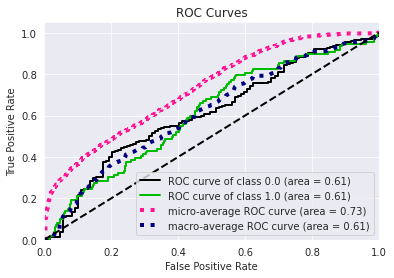

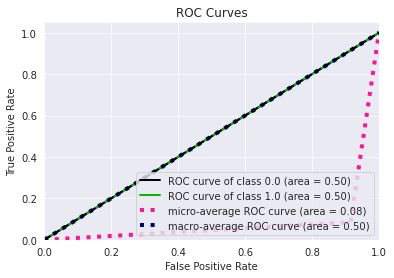

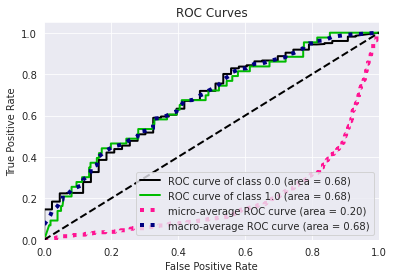

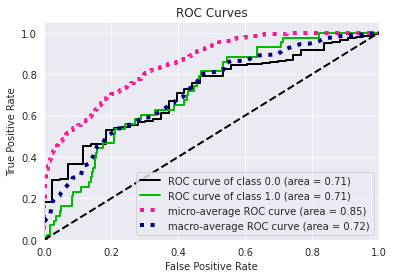

In [42]:
fig= plt.figure(figsize=(20,40))
for i in range(len(X_train)):
    # ax= fig.add_subplot(len(X_train), 1, i+1)
    plot_roc(y_test[i], y_predicted[i])
    # title= 'Paciente {0}'.format(i)
    # ax.set_title(title)
plt.show()

Al analizar las curvas ROC (curva característica operativa del receptor) y la AUC (área bajo la curva) respectiva, se observa que para los conjuntos de datos de validación de los tres pacientes y del paciente tres, ambas curvas de desprenden de la recta a 45º o del "clasificador aleatorio". Esto se interpreta y/o nos dice que el clasificador da cierta información relevante. Un aspecto interesante que se pone de manifiesto con este modo de presentación de los resultados, es la curva micro-average para los pacientes dos y tres, claramente e independientemente de la curva macro-average que se encuentra por encima de la curva de un caso aleatorio, reflejan el desbalanceo de los etiquetas correspondientes a los estadíos interictal y preictal (idem análisis del caso base). 

No obstante lo mencionado y en función del detallado análisis para el caso base (extensible al resto de modelos inclusive con ajuste de hiperparámetros, seleccón del modelo y ala corrida de los mejores con Kfold), estas métricas, mejoradas respecto al caso base, no son representativas del caso objeto de estudio y para la validación de un modelo deberá analizarse las métricas precission y recall. 

NOTA: la diferencia entre las curvas correspondientes a los promedios "macro" y "micro", es que para el trazado de la curva "macro" cada clase se pondera igual, mientras que para graficar la curva "micro", cada  registro se pondera igual. Es decir, si la cantidad de registros para cada clase son iguales, las curvas "macro" y "micro" coincidirán. Dicho de otra manera, podemos pensar en:
* un "macropromedio": en este  la métrica para cada clase se calcula independientemente de la cantidad de registros que correponda a cada una y luego se calcula su promedio o media arirmética; en este caso, no se ponderan las clases en función de su cantidad,
* un micropromedio contempla las contribución de cada clase para calcular la métrica (promedio), por ej. el micro-average es igual a la métrica precission (VP/VP+FP), con VP: verdaderos positivos y FP: falsos positivos.

In [43]:
[print(classification_report(y_test[i], np.argmax(y_predicted[i], axis=1))) for i in range(len(X_train))]

              precision    recall  f1-score   support

         0.0       0.94      0.65      0.77      1509
         1.0       0.08      0.44      0.14       109

    accuracy                           0.64      1618
   macro avg       0.51      0.55      0.46      1618
weighted avg       0.88      0.64      0.73      1618

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       291
         1.0       0.08      1.00      0.16        27

    accuracy                           0.08       318
   macro avg       0.04      0.50      0.08       318
weighted avg       0.01      0.08      0.01       318

              precision    recall  f1-score   support

         0.0       0.98      0.19      0.32       477
         1.0       0.10      0.95      0.17        43

    accuracy                           0.25       520
   macro avg       0.54      0.57      0.25       520
weighted avg       0.91      0.25      0.31       520

              preci

[None, None, None, None]

**Corremos los dos modelos con un KFoold**

['scaledRF']: 0.894787 (0.011466)
['scaledRF', 'scaledXGB']: 0.882345 (0.012719)
Paciente 0


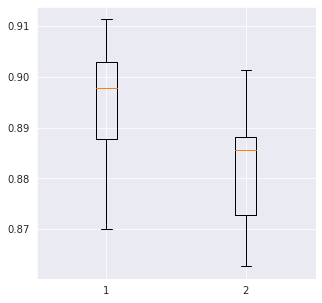

['scaledRF']: 0.869975 (0.031972)
['scaledRF', 'scaledXGB']: 0.862529 (0.027991)
Paciente 1


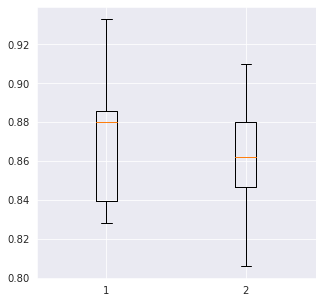

['scaledRF']: 0.903273 (0.017685)
['scaledRF', 'scaledXGB']: 0.918944 (0.020090)
Paciente 2


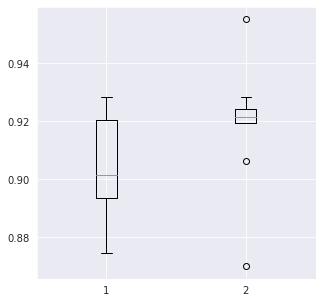

['scaledRF']: 0.916402 (0.011930)
['scaledRF', 'scaledXGB']: 0.918394 (0.019809)
Paciente 3


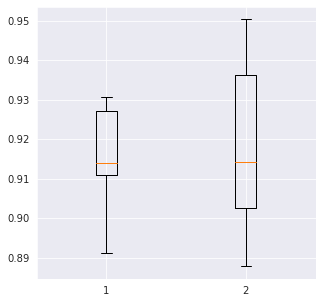

In [44]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

# add params-.
pipelines = []
pipelines.append(('scaledRF', (Pipeline([('ss' , StandardScaler()),
                                         ('RF' ,ensemble.RandomForestClassifier(
                                             #n_estimators= st.randint(20,150), # n. de árboles.
                                             #max_depth= st.randint(3, 12),     # máxima profundiad del árbol
                                             #criterion= ['gini', 'entropy'],
                                             random_state= rs))]
                                       )
                              )
                 )
                )
pipelines.append(('scaledXGB' , (Pipeline([('ss' , StandardScaler()),
                                           ('XGB' ,XGBClassifier(random_state=rs))]
                                         )
                                )
                 )
                )
                                          
fig.suptitle('Comparacion de Algoritmos de clasificacion')
for i in range(len(dfs)):
    model_name = []
    results = []
    for pipe, model in pipelines:
        kfold = KFold(n_splits=10, random_state=rs, shuffle=True)
        crossv_results = cross_val_score(model , X_train[i] ,y_train[i] ,cv =kfold , scoring='accuracy')
        results.append(crossv_results)
        model_name.append(pipe)
        msg = "%s: %f (%f)" % (model_name, crossv_results.mean(), crossv_results.std())
        print(msg)
    #
    ax= fig.add_subplot(len(X_train), 1, i+1)
    fig= plt.figure(figsize=(5,5))
    plt.boxplot(results)
    ax.set_xticklabels(model_name)
    title= print('Paciente {0}'.format(i))
    ax.set_title(title)
    plt.show()

### Conclusión:

A partir del desarrollo del trabajo y del análisis y de las conclusiones parciales presentandas, se concluye que:

1. Teniendo en cuenta que se cuenta con pocos registros y el desbalanceo de los conjuntos de datos, de ahora en más debería trabajarse con el dataset correspondiente a los tres pacientes.
2. Teniendo en cuenta que la dimensión del conjunto de datos es pequeña, el balanceo con ADASYN se considera el adecuado (para conlusiones parciales de porqué no aplicar otros tipos de balanceos ir a la sección correspondiente). 
2. Aplicar una selección de features no mejora las métricas sustancialmente.
3. La métrica accuracy es alta y no es representativa de la calidad de los modelos presentados.
4. Solo para el caso de los tres pacientes juntos se logra un modelo con "una" capacidad predictiva.
5. En general y teniendo en cuenta la dominio de aplicación de los datos, las métricas obtenidas no son adecuadas para la aplicación del modelo.
6. En general y al analizar diferentes modelos de clasificación al del caso base, junto a la selección de hiperparámetros y finalmente luego de correrlos con un Kfold, la métrica general accuracy (que representa la cantidad total de veces que el modelo acierta respecto al total de los datos de entrada), mejora. Sin embargo y tal como se mencionó al analizar las curvas ROC y la AUX correspondiente, esta métrica no es representativa del o de los modelos objetos de estudio.  